In [23]:
from hmmlearn import hmm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima.metrics import smape

In [24]:
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
punktlighed_per_date = data.groupby('dato')['togpunktlighed'].mean().reset_index()

# All data

In [9]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(punktlighed_per_date, test_size=0.2, random_state=42, shuffle=False)

# Extract precision labels for training
y_train = train_data['togpunktlighed'].values.reshape(-1, 1)

# Define the HMM model
model = hmm.GaussianHMM(n_components=10, covariance_type="full")

# Train the HMM model
model.fit(y_train)

# Extract precision labels for the testing set
y_test = test_data['togpunktlighed'].values.reshape(-1, 1)

# Predict the most likely sequence of hidden states (precision levels) for the testing set
predicted_states = model.predict(y_test)

In [4]:
model.predict(y_train).shape

(2045,)

In [11]:
# Extract means of Gaussian distributions associated with each hidden state
means = model.means_

# Initialize a list to store the predicted precision values
predicted_precision_values = []

# Iterate through each predicted state
for i, state in enumerate(predicted_states):
    # Retrieve the mean associated with the predicted hidden state
    mean_for_state = means[state][0]
    # Append the mean to the list after any necessary transformation
    # (you can adjust this transformation based on your data and problem)
    predicted_precision_values.append(mean_for_state)

# Calculate the predicted precision for the testing set
mse = mean_squared_error(y_test, predicted_precision_values)
smapes = smape(y_test, predicted_precision_values)

print("MSE:", mse)
print("SMAPE:", smapes)

MSE: 0.0030023109722098875
SMAPE: 5.436523547980756


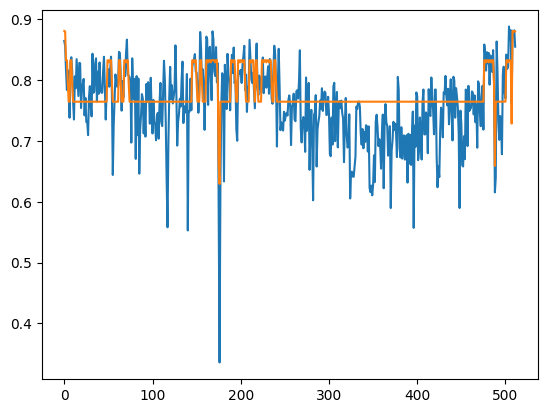

In [12]:
plt.plot(y_test)
plt.plot(predicted_precision_values)

In [13]:
# Extract means of Gaussian distributions associated with each hidden state
means = model.means_

# Initialize a list to store the predicted precision values
predicted_precision_values = []

y_state = y_train[-1]
# Iterate through each predicted state
for i, state in enumerate(predicted_states):
    # Retrieve the mean associated with the predicted hidden state
    mean_for_state = means[state][0]
    mean_for_state = np.mean([y_state[0], mean_for_state])
    y_state = y_test[i-1]
    # Append the mean to the list after any necessary transformation
    # (you can adjust this transformation based on your data and problem)
    predicted_precision_values.append(mean_for_state)

# Calculate the predicted precision for the testing set
mse = mean_squared_error(y_test, predicted_precision_values)
smapes = smape(y_test, predicted_precision_values)

print("MSE:", mse)
print("SMAPE:", smapes)

MSE: 0.003148495350989782
SMAPE: 5.572867909225499


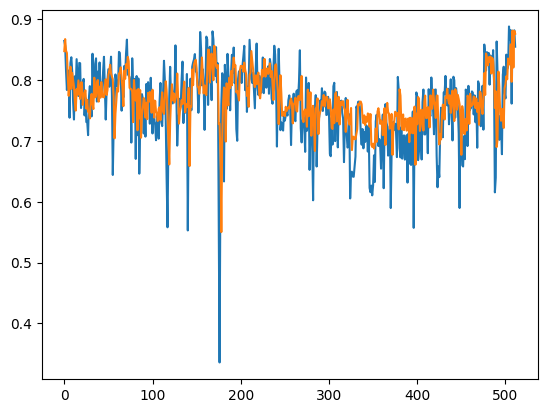

In [14]:
plt.plot(y_test)
plt.plot(predicted_precision_values)

# True way to do it (I think)

In [35]:
np.random.seed(26)
# Split the data into training and testing sets
train_data, test_data = train_test_split(punktlighed_per_date, test_size=0.2, random_state=42, shuffle=False)

# Extract precision labels for training
y_train = train_data['togpunktlighed'].values.reshape(-1, 1)

# Extract precision labels for the testing set
y_test = test_data['togpunktlighed'].values.reshape(-1, 1)

# Define the HMM model
model = hmm.GaussianHMM(n_components=10, covariance_type="full", algorithm='viterbi')

# Train the HMM model
model.fit(y_train)

#######################################################################
# Predict ten steps forward via a loop
# Initialize an array to store predicted values
predicted_values = []

# Start prediction loop
for i in range(len(y_test)):
    # Last hidden state from training
    last_state = model.predict(y_train)[-1]

    # State transition matrix
    next_state_probs = model.transmat_[last_state]
    next_state = np.argmax(next_state_probs)

    # Get the parameters of the Gaussian distribution from the predicted next state 
    mean_next_state = model.means_[next_state]
    covar_next_state = model.covars_[next_state]

    # Predict the next value via sampling, can also use the mean of the state as the predicted next value
    predicted_next_value = np.random.multivariate_normal(mean_next_state.ravel(), covar_next_state)
    predicted_values.append(predicted_next_value[0])

    # Update training data with the predicted value for the next iteration
    #y_train = np.append(y_train, predicted_next_value.reshape(1, -1), axis=0)
    # Update with true value
    y_train = np.append(y_train, y_test[i].reshape(1,-1), axis=0)

# Print predicted values
print("Predicted values for the next len(y_test) steps:", predicted_values)

Predicted values for the next len(y_test) steps: [0.8201421494099489, 0.8066815247883218, 0.897254582703037, 0.8530730023751862, 0.8075605541073875, 0.7636293207266505, 0.7230645714520021, 0.8160537940630284, 0.7593520336908439, 0.8001123389562682, 0.7875382841016099, 0.8764929866269077, 0.7725652461658113, 0.8188362758670881, 0.7674724917125243, 0.752385146396338, 0.7943886165455962, 0.7628823758607479, 0.7538259491490746, 0.8143830335678357, 0.7911535899956691, 0.8435636688510041, 0.7183718836005822, 0.8708506435030721, 0.8228030642939121, 0.7791287912126191, 0.8207302794179068, 0.8181764600238681, 0.8999196616162006, 0.7266720673370635, 0.7658423716923651, 0.6959213826946933, 0.7490634798755461, 0.7288892833070365, 0.6360666131810335, 0.8684551454882975, 0.8036646633827874, 0.7646362082088984, 0.8068139679220458, 0.7819347646745989, 0.8467838662766833, 0.8295408105932242, 0.806105310515756, 0.8231846319272103, 0.7916862831950199, 0.8480894029762783, 0.8039622285534962, 0.75703511513

In [36]:
# Calculate the predicted precision for the testing set
mae = mean_absolute_error(y_test, predicted_values)
smapes = smape(y_test, predicted_values)

print("MAE:", mae)
print("SMAPE:", smapes)

MAE: 0.05861199787675041
SMAPE: 7.828752078569892


# Per strækning

In [56]:
def togpunktlighed_split(feature, feature_n, ratio=0.1):
    strækning_data = data[data[feature] == feature_n]
    togpunktlighed_strækning_daily = strækning_data.groupby('dato')['togpunktlighed'].mean().reset_index()
    train, test = train_test_split(togpunktlighed_strækning_daily, test_size=ratio, shuffle=False)
    return train,test

In [57]:
def plotting_results(feature, feature_n, train, test, forecasts):
    #fig, axes = plt.subplots(1, 1, figsize=(20, 8))

# --------------------- Actual vs. Predicted --------------------------
    plt.plot(train['dato'], train['togpunktlighed'], color='blue', label='Training Data')
    plt.plot(test['dato'], test['togpunktlighed'], color='red', label='Test Data')
    plt.plot(test['dato'], forecasts, color='green', marker='x',
             label='Predictions')
    plt.title(f'{feature.capitalize() } {feature_n}: Predictions & True Value')
    plt.xlabel('Dates')
    plt.ylabel('Togpunktlighed')

    #plt.set_xticks(np.arange(0, y_train.shape[0]+y_test.shape[0], 366).tolist(), togpunktlighed_daily['year'][0:y_train.shape[0]+y_test.shape[0]:366].tolist())
    plt.legend(loc='lower left')
    plt.show()

In [58]:
data_each_strækning = {}
for strækning in np.sort(data['visualiseringskode'].unique()):
    train, test = togpunktlighed_split('visualiseringskode', strækning, ratio=0.1)
    y_train, y_test = train['togpunktlighed'].values.reshape(-1, 1), test['togpunktlighed'].values.reshape(-1, 1)

    # Train the HMM model
    model = hmm.GaussianHMM(n_components=10, covariance_type="full")
    model.fit(y_train)

    # Extract precision labels for the testing set
    #y_test = test_data['togpunktlighed'].values.reshape(-1, 1)

    # Predict the most likely sequence of hidden states (precision levels) for the testing set
    predicted_states = model.predict(y_test)

    # Extract means of Gaussian distributions associated with each hidden state
    means = model.means_

    # Initialize a list to store the predicted precision values
    predicted_precision_values = []

    y_state = y_train[-1]
    # Iterate through each predicted state
    for i, state in enumerate(predicted_states):
        # Retrieve the mean associated with the predicted hidden state
        mean_for_state = means[state][0]
        mean_for_state = np.mean([y_state[0], mean_for_state])
        y_state = y_test[i-1]
        # Append the mean to the list after any necessary transformation
        # (you can adjust this transformation based on your data and problem)
        predicted_precision_values.append(mean_for_state)
    # Calculate the predicted precision for the testing set
    mse = mean_squared_error(y_test, predicted_precision_values)
    smapes = smape(y_test, predicted_precision_values)

    results = [strækning, train, test, predicted_precision_values, model, mean_squared_error(y_test, predicted_precision_values), smape(y_test, predicted_precision_values)]
    data_each_strækning[strækning] = results
    print(1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


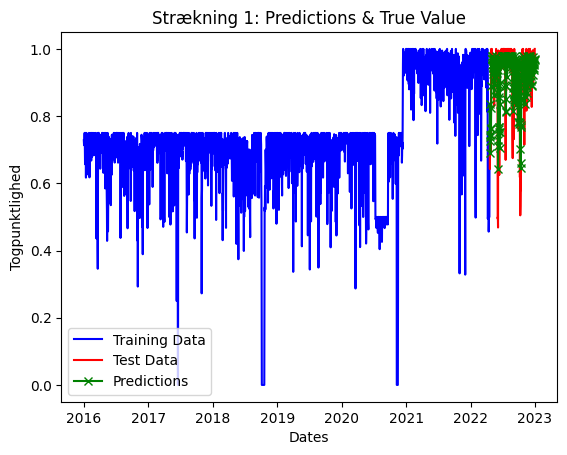

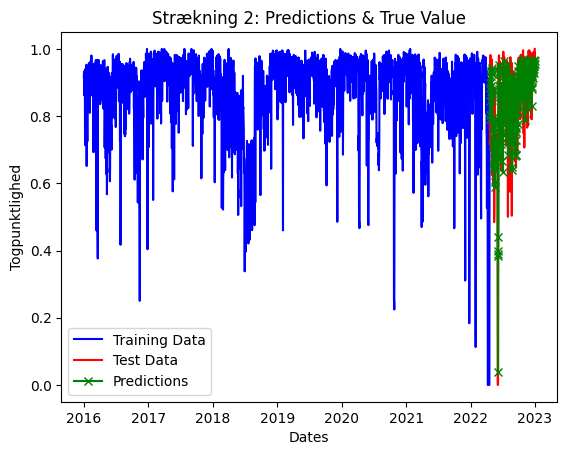

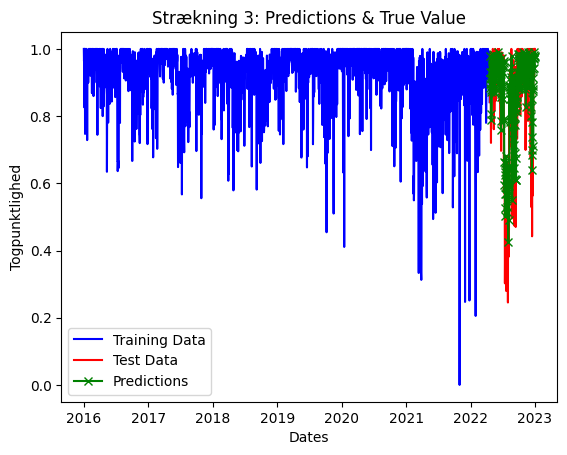

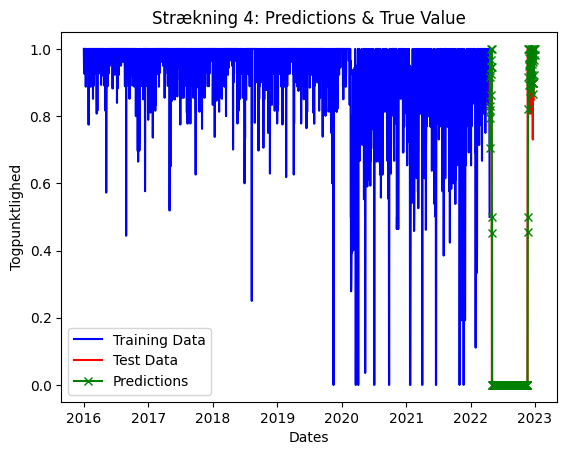

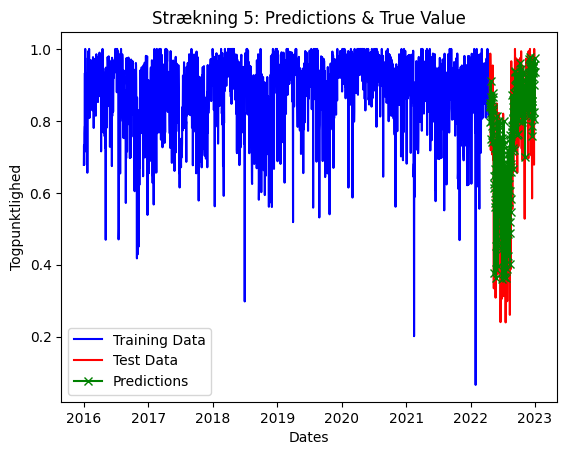

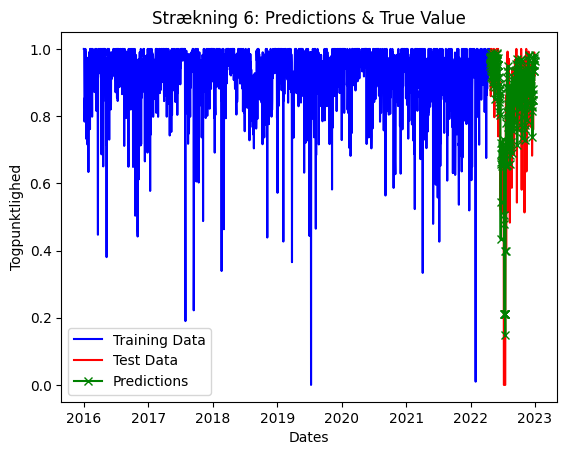

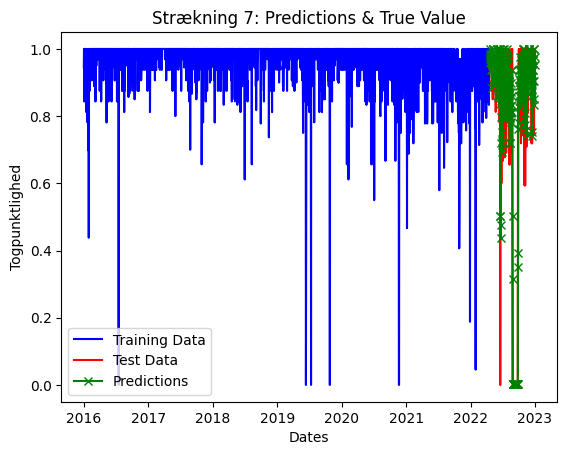

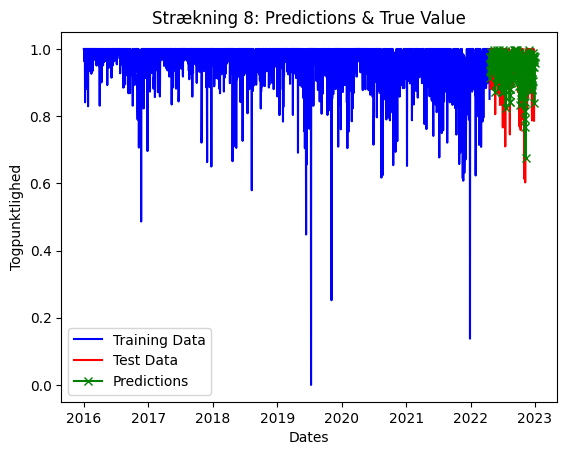

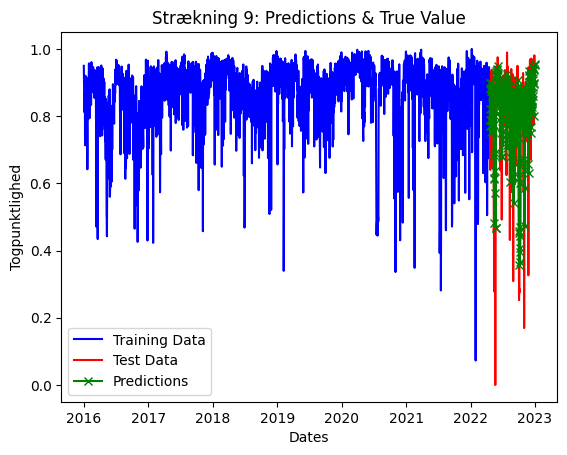

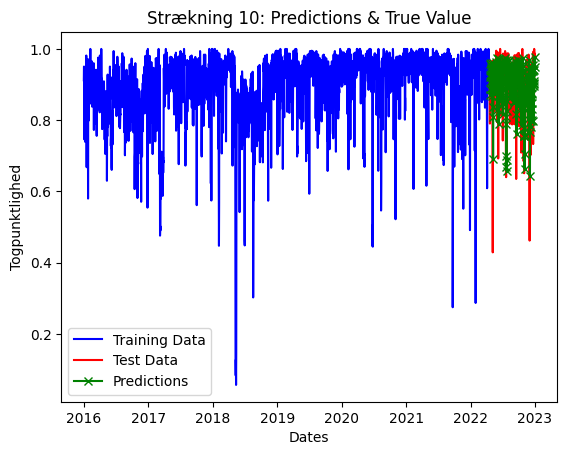

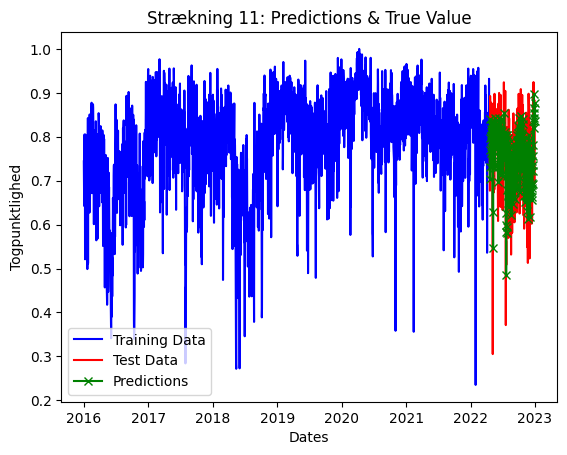

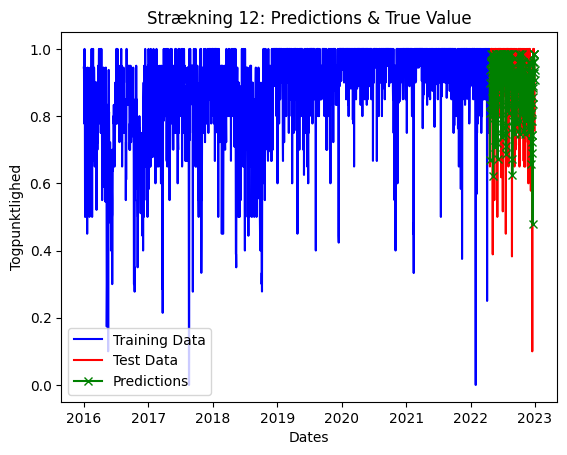

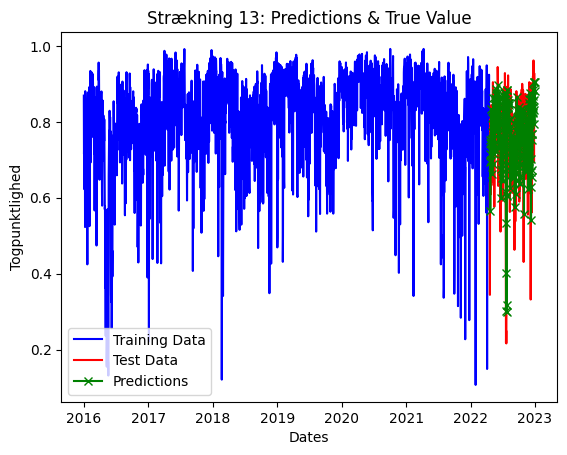

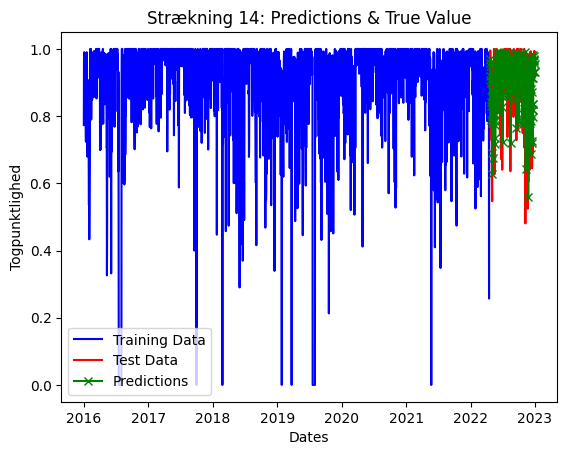

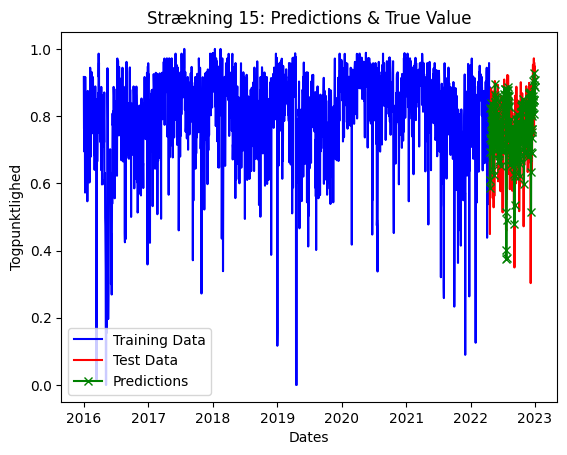

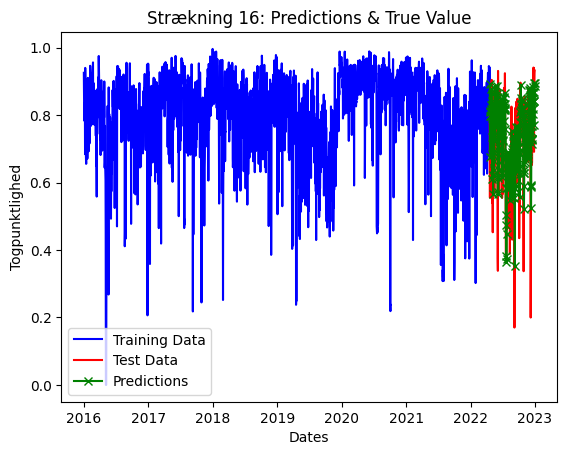

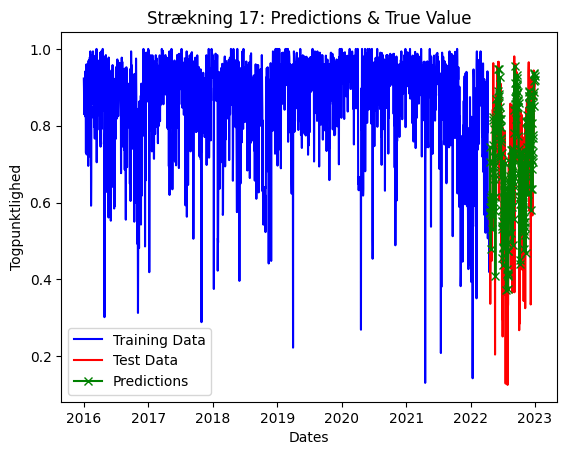

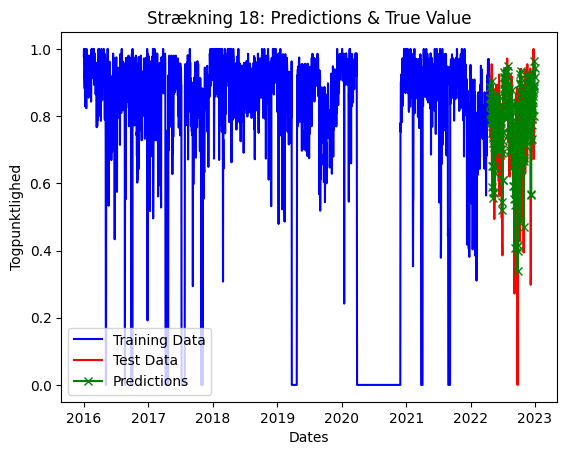

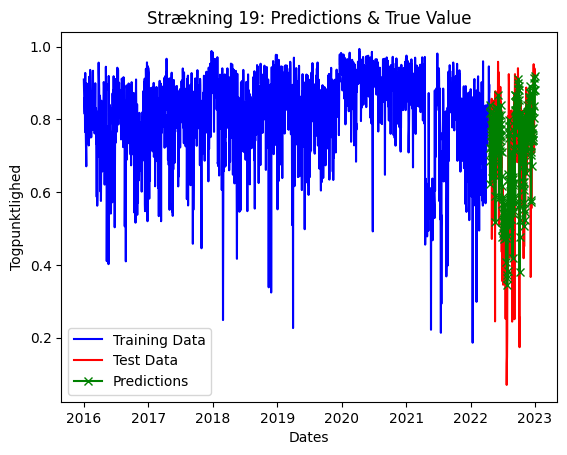

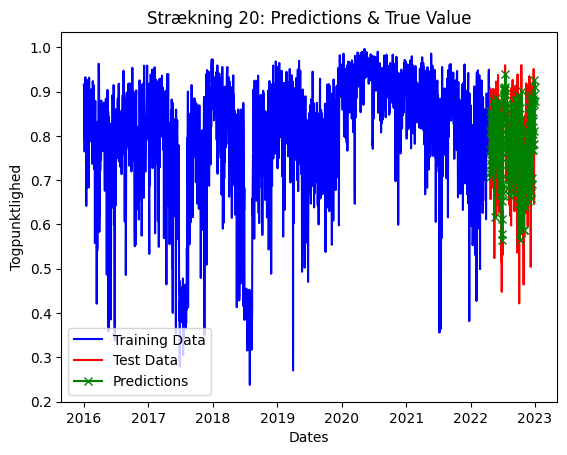

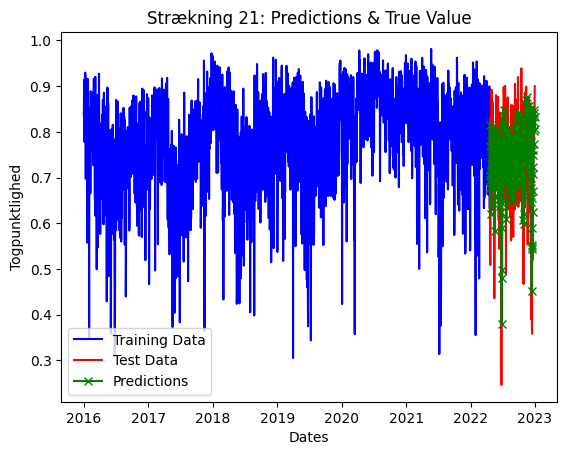

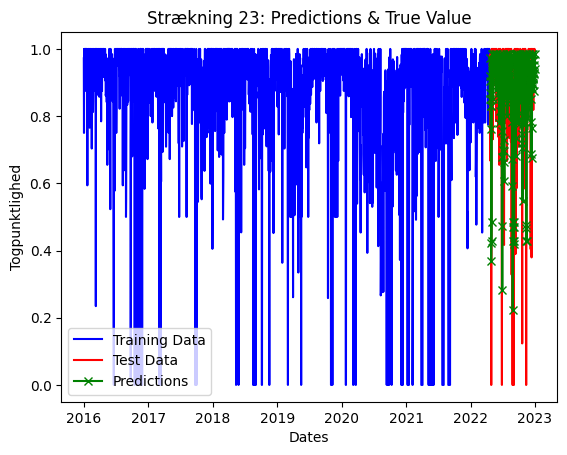

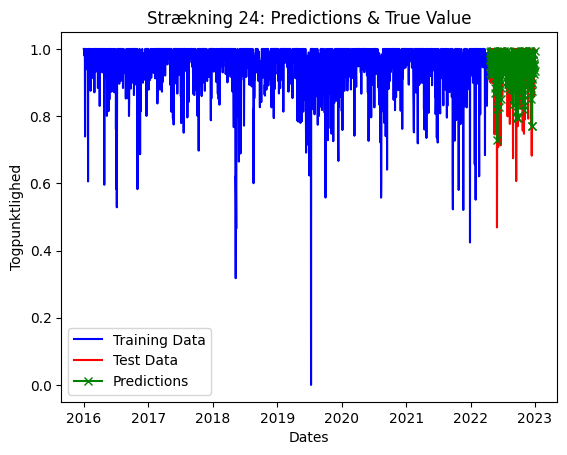

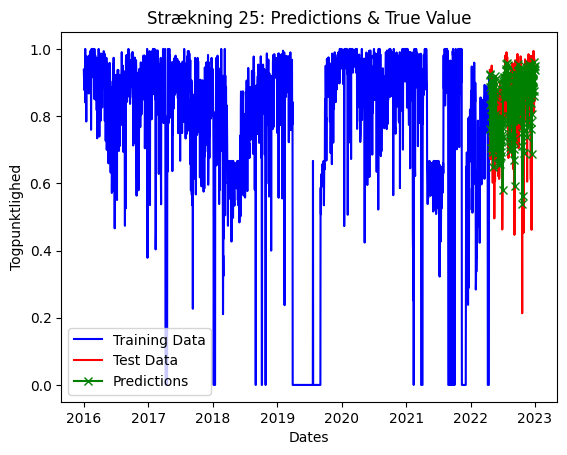

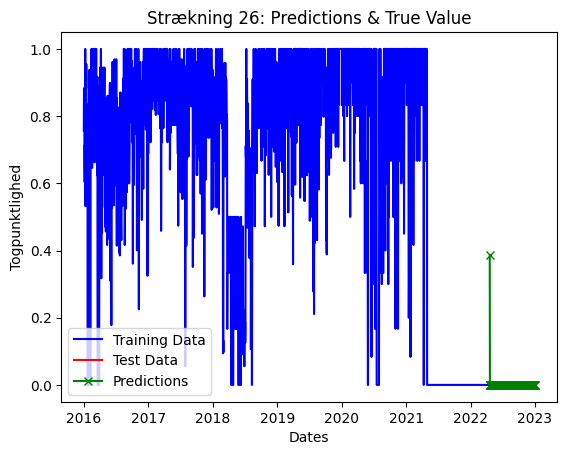

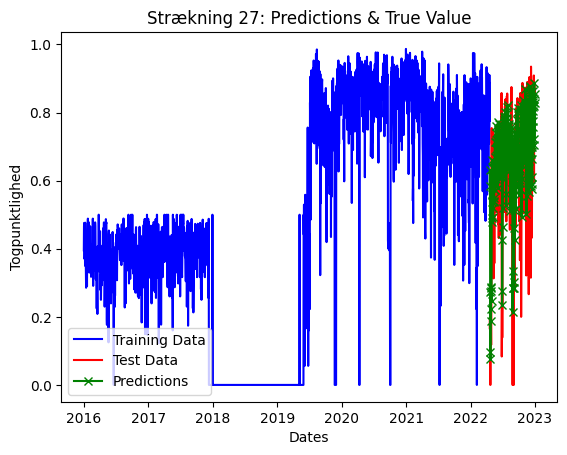

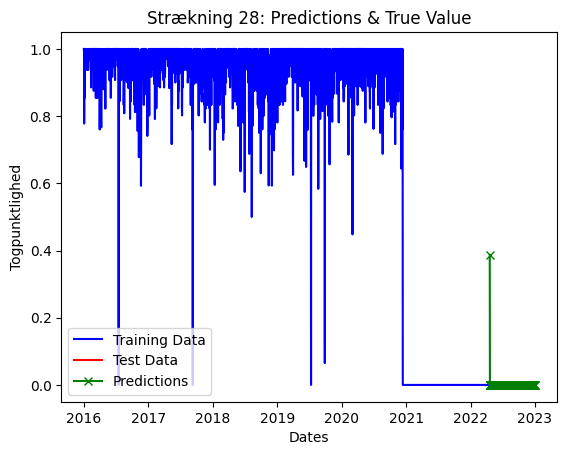

In [59]:
for strækning, results in data_each_strækning.items():
    _, train, test, forecasts, _, _, _ = results
    plotting_results('Strækning',strækning, train, test, forecasts)

# Per station

In [60]:
data_each_station = {}
for station in np.sort(data['station'].unique()):
    train, test = togpunktlighed_split('station', station, ratio=0.1)
    y_train, y_test = train['togpunktlighed'].values.reshape(-1, 1), test['togpunktlighed'].values.reshape(-1, 1)

    # Train the HMM model
    model = hmm.GaussianHMM(n_components=10, covariance_type="full")
    model.fit(y_train)

    # Extract precision labels for the testing set
    #y_test = test_data['togpunktlighed'].values.reshape(-1, 1)

    # Predict the most likely sequence of hidden states (precision levels) for the testing set
    predicted_states = model.predict(y_test)

    # Extract means of Gaussian distributions associated with each hidden state
    means = model.means_

    # Initialize a list to store the predicted precision values
    predicted_precision_values = []

    y_state = y_train[-1]
    # Iterate through each predicted state
    for i, state in enumerate(predicted_states):
        # Retrieve the mean associated with the predicted hidden state
        mean_for_state = means[state][0]
        mean_for_state = np.mean([y_state[0], mean_for_state])
        y_state = y_test[i-1]
        # Append the mean to the list after any necessary transformation
        # (you can adjust this transformation based on your data and problem)
        predicted_precision_values.append(mean_for_state)
    # Calculate the predicted precision for the testing set
    mse = mean_squared_error(y_test, predicted_precision_values)
    smapes = smape(y_test, predicted_precision_values)

    results = [station, train, test, predicted_precision_values, model, mean_squared_error(y_test, predicted_precision_values), smape(y_test, predicted_precision_values)]
    data_each_station[station] = results
    print(1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


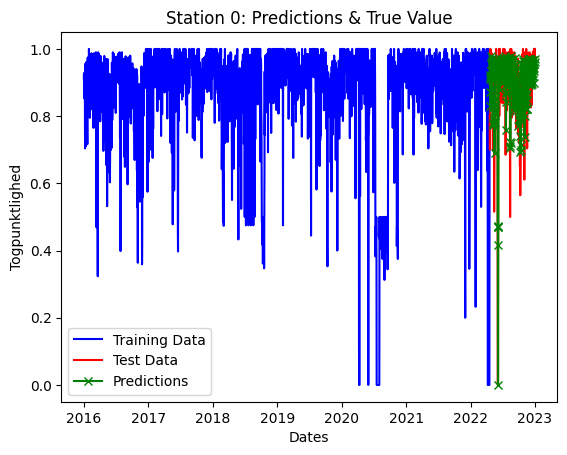

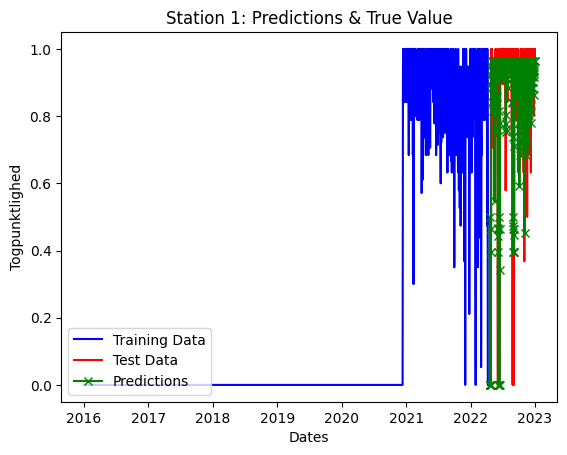

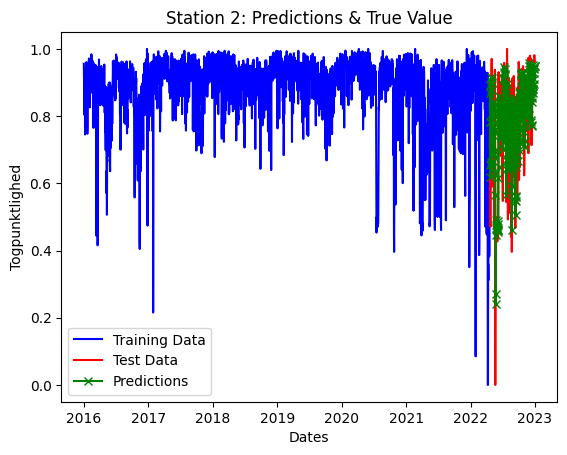

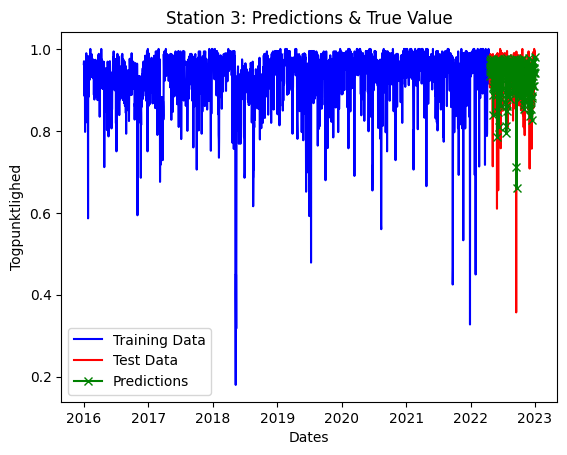

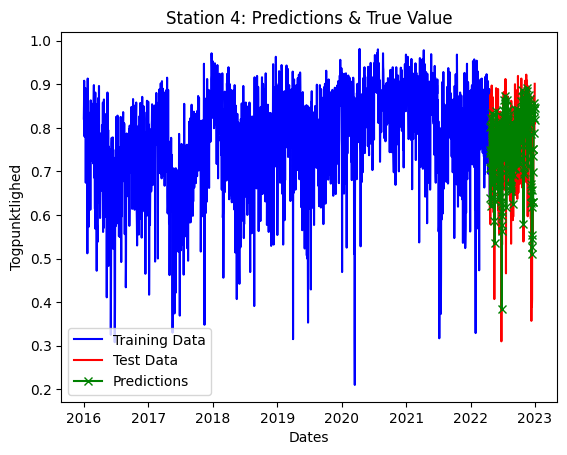

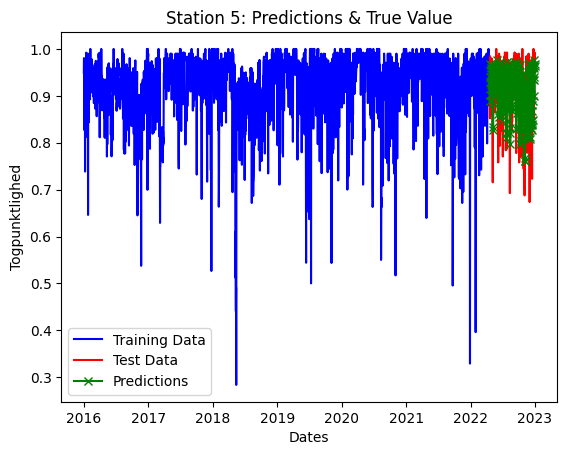

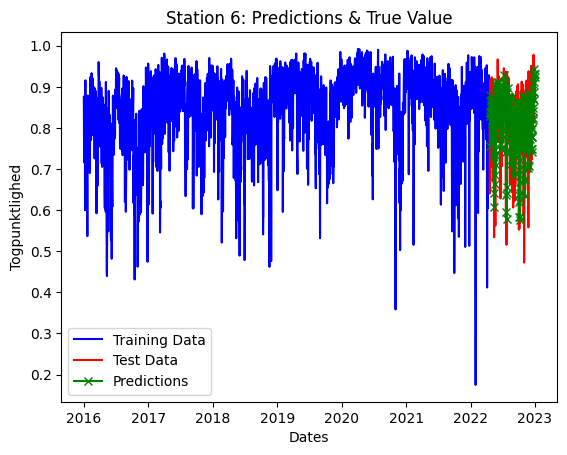

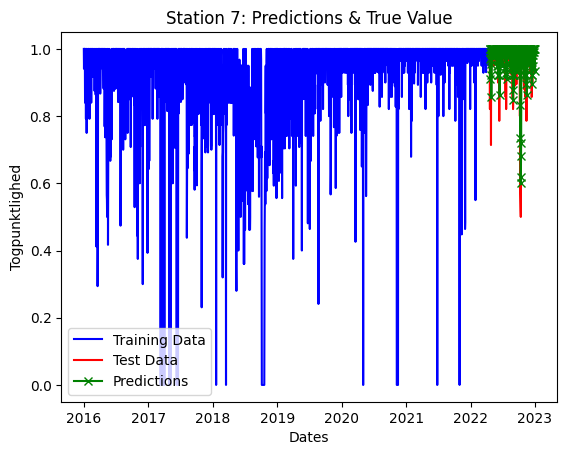

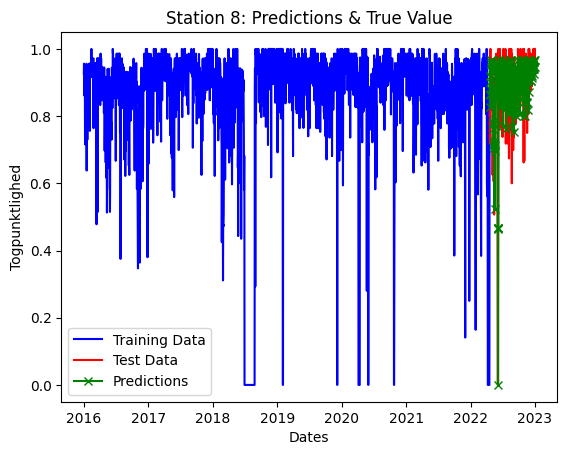

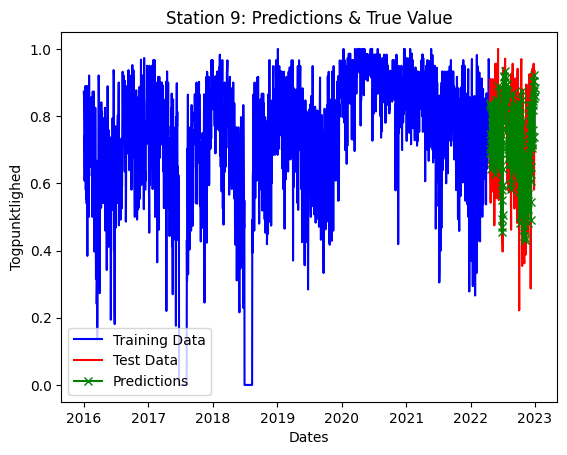

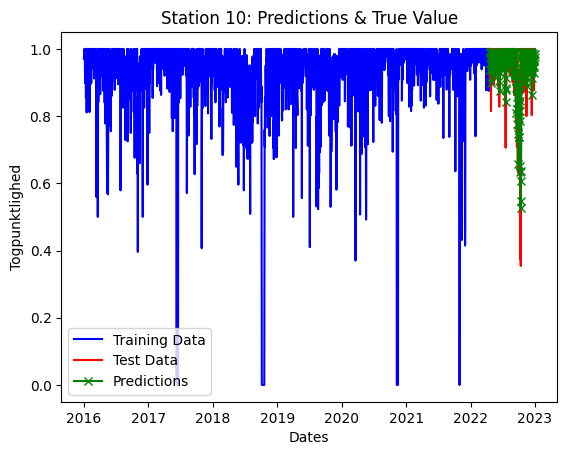

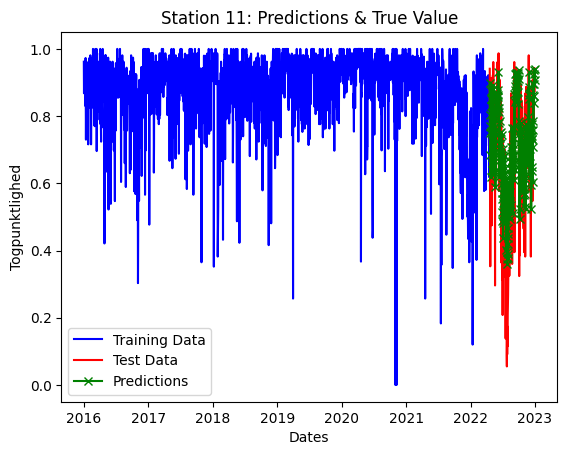

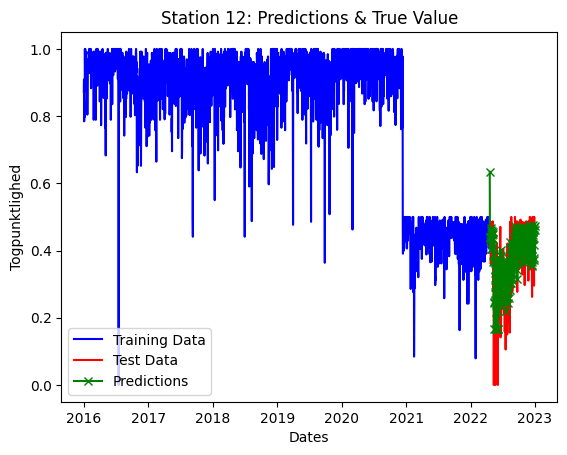

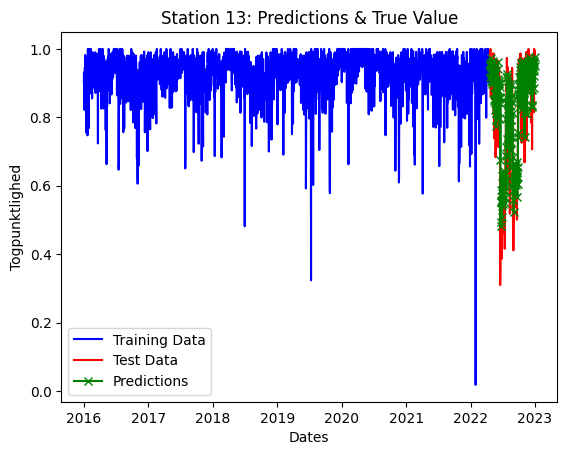

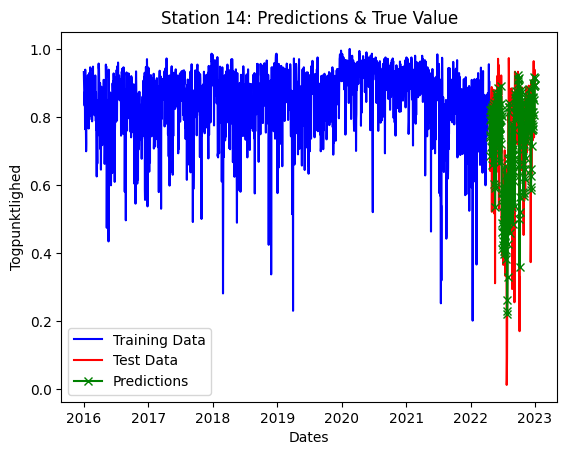

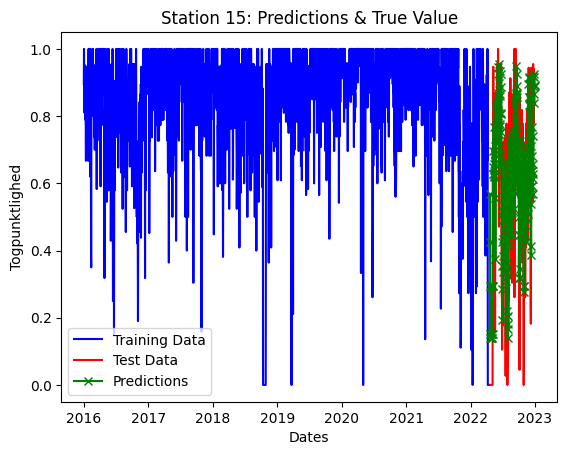

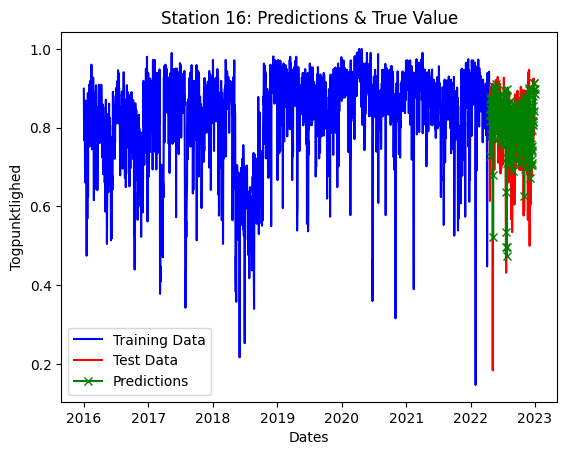

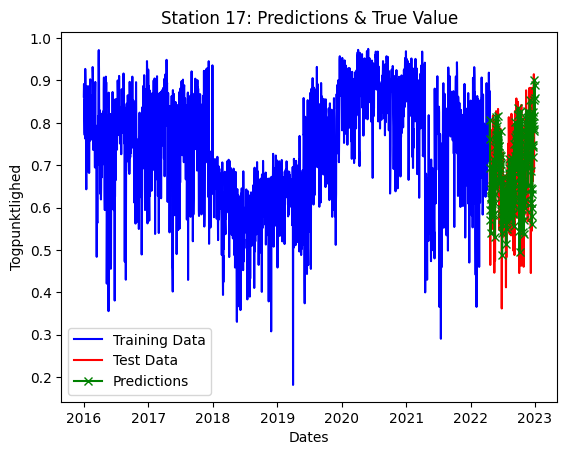

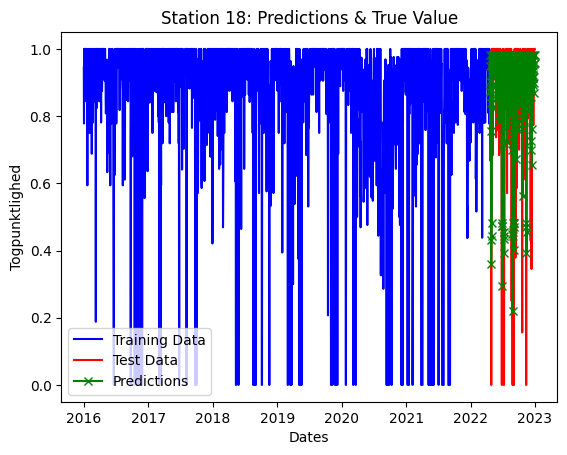

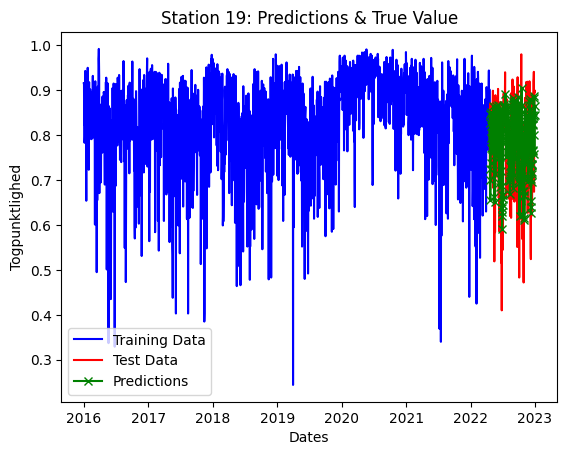

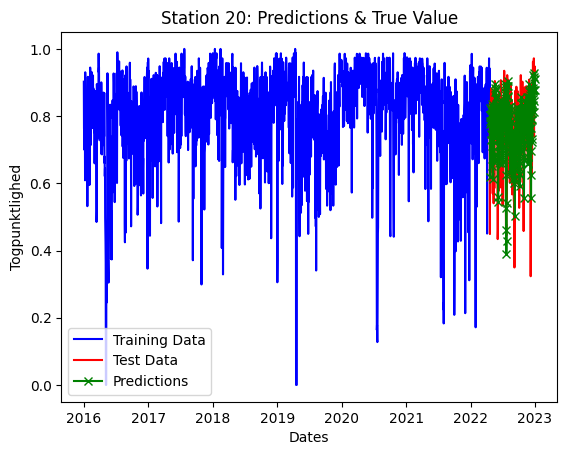

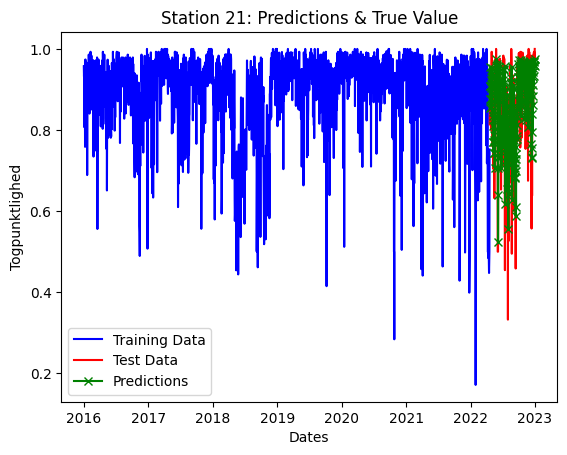

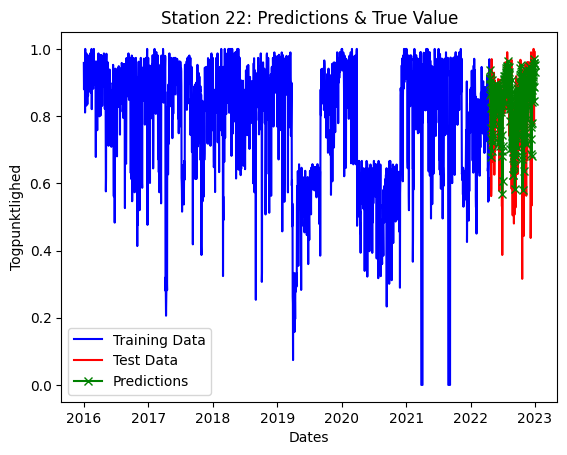

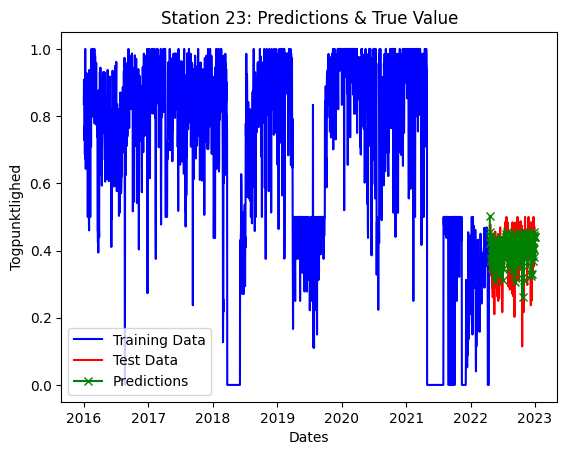

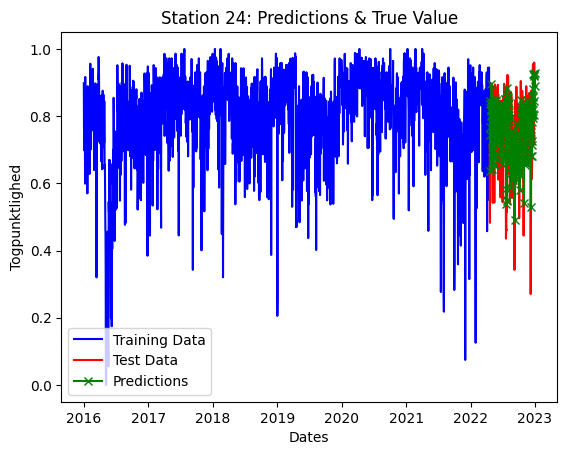

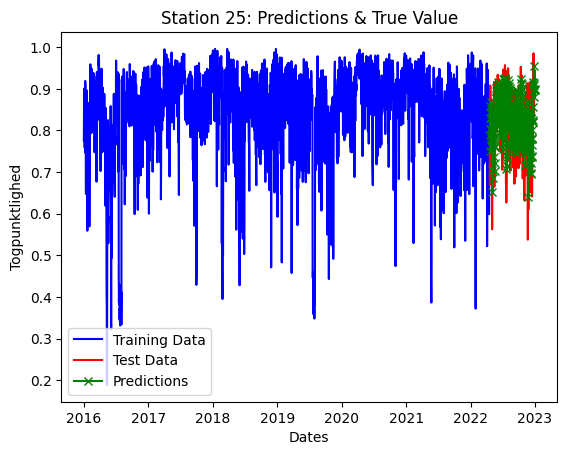

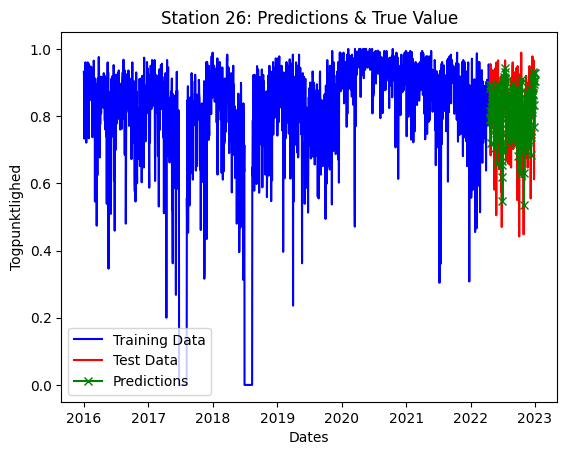

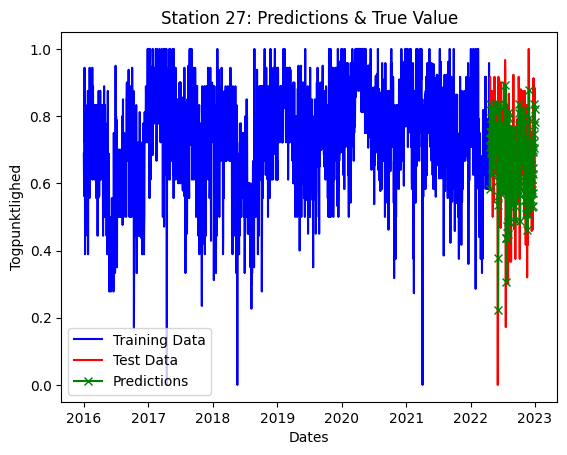

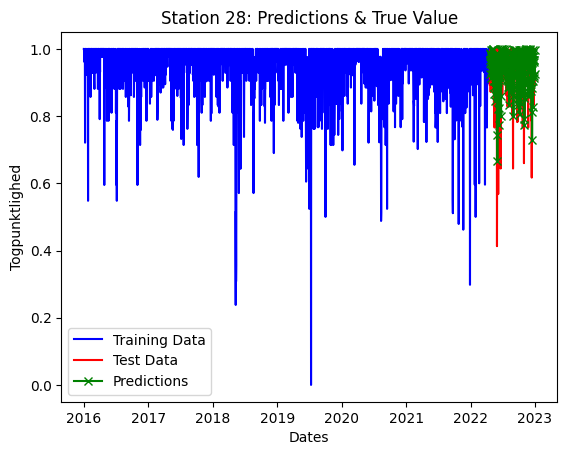

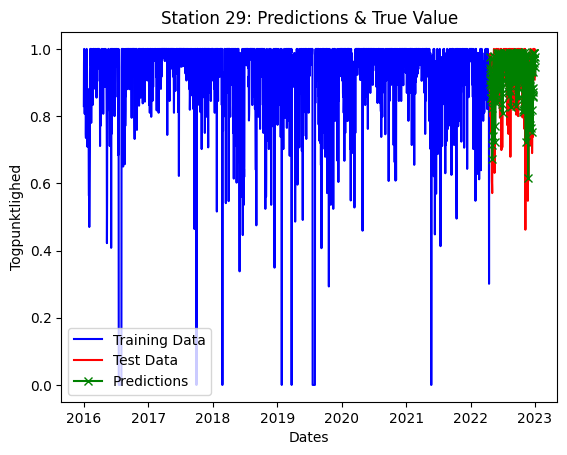

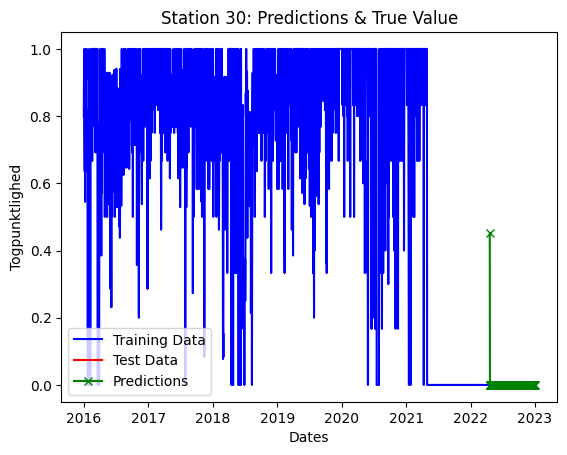

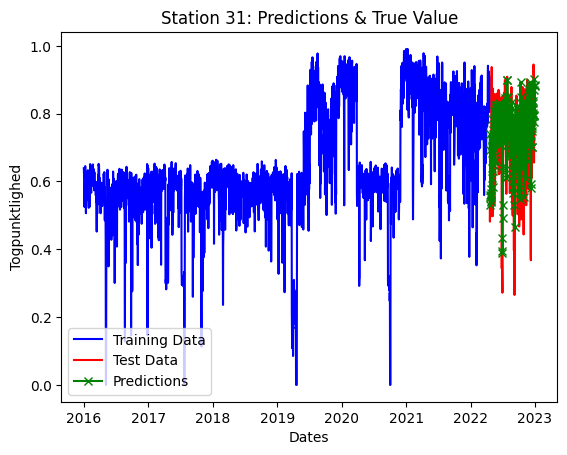

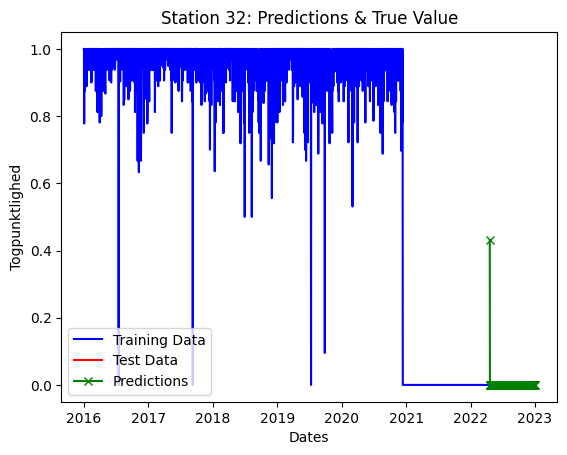

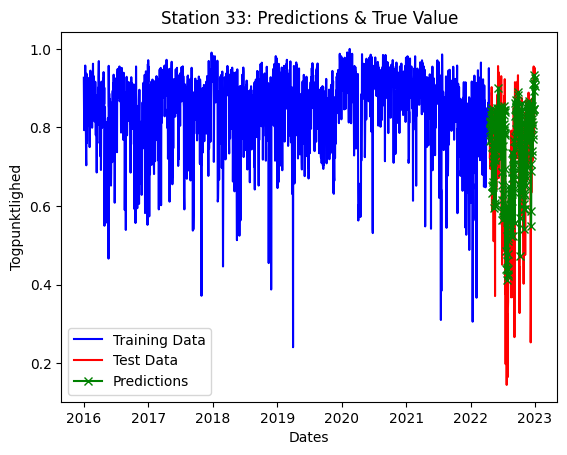

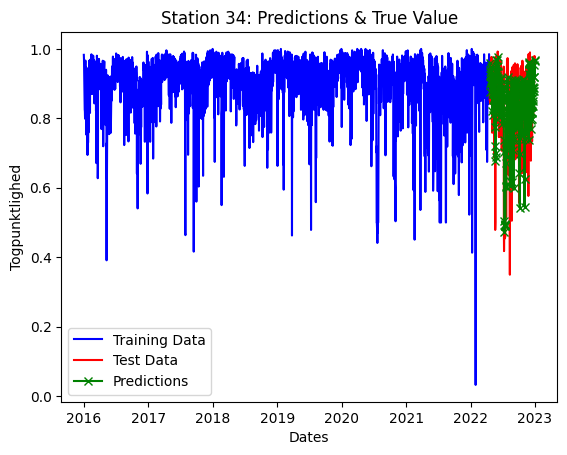

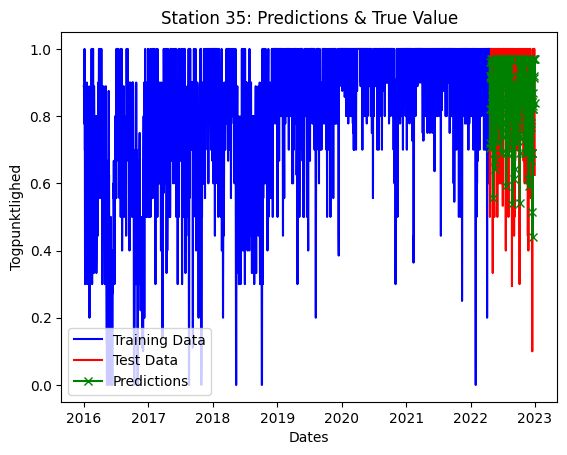

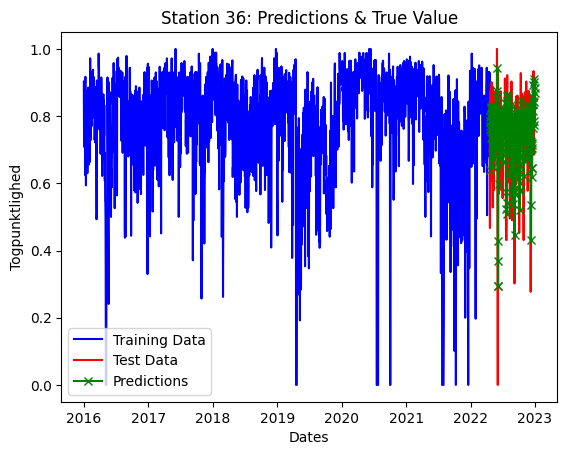

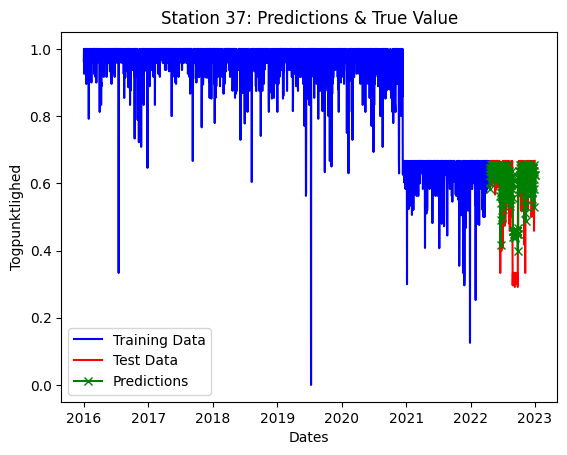

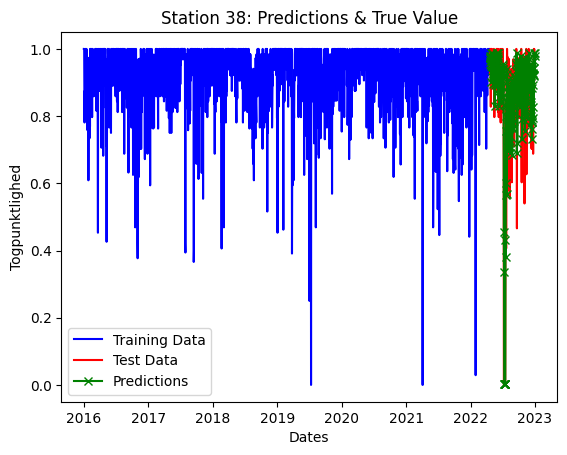

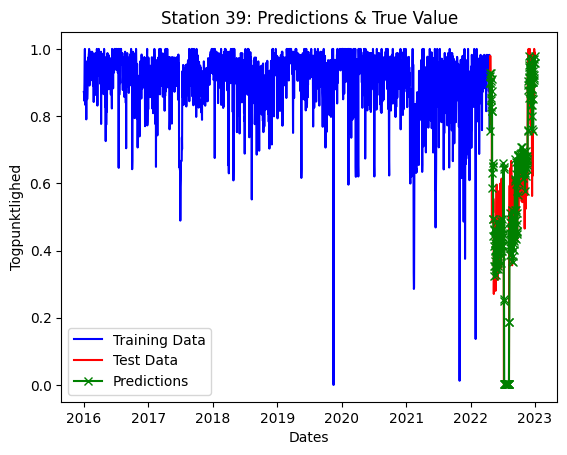

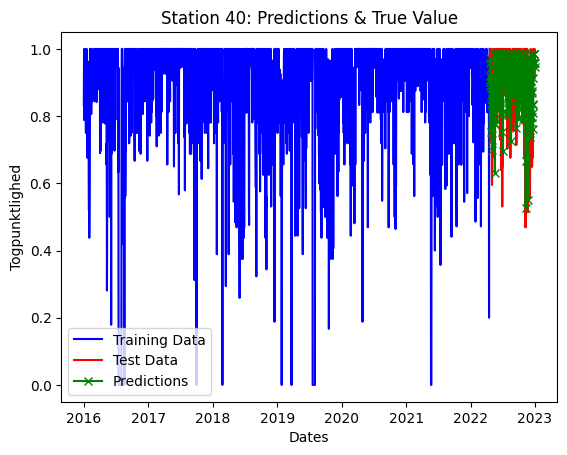

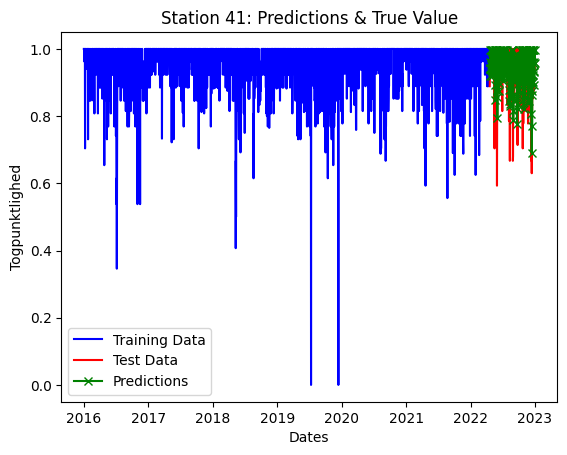

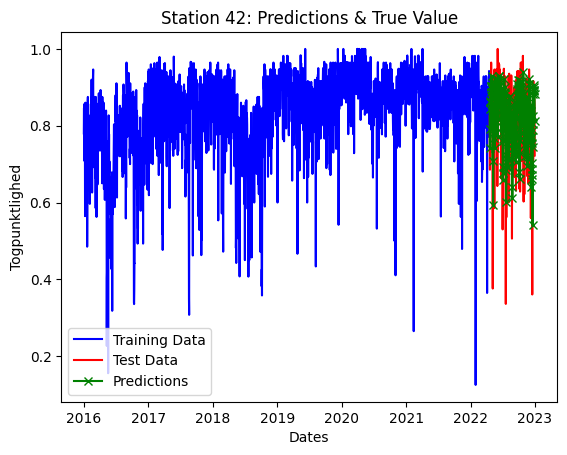

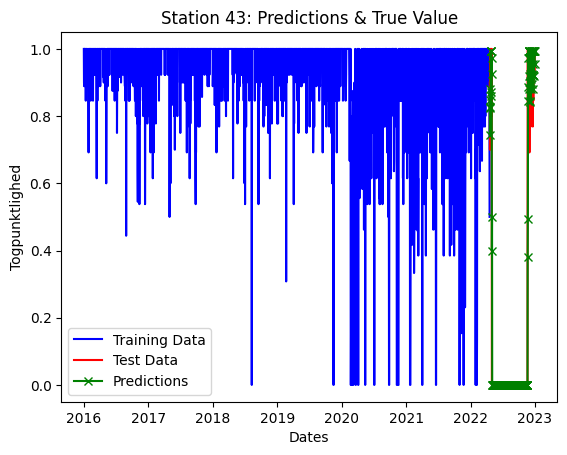

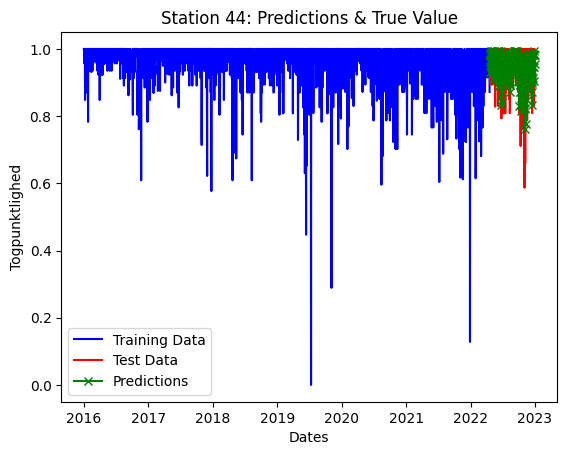

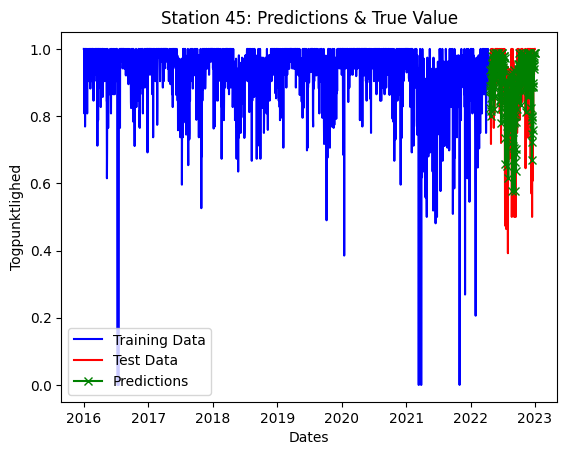

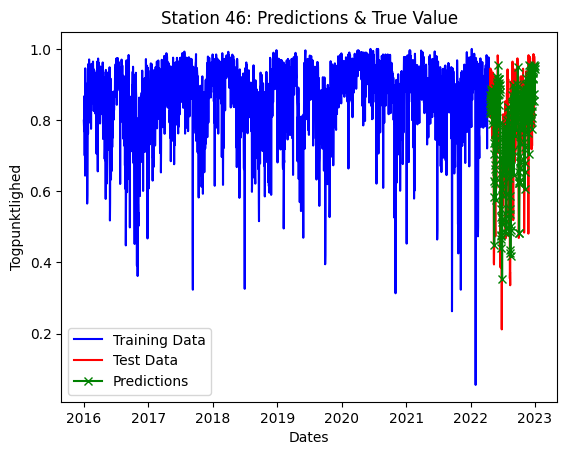

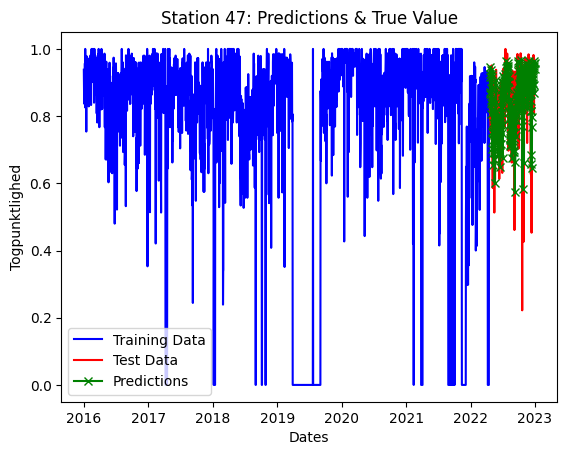

In [61]:
for station, results in data_each_station.items():
    _, train, test, forecasts, _, _, _ = results
    plotting_results('Station',station, train, test, forecasts)

# Errors
Eventuelt også med SMAPE

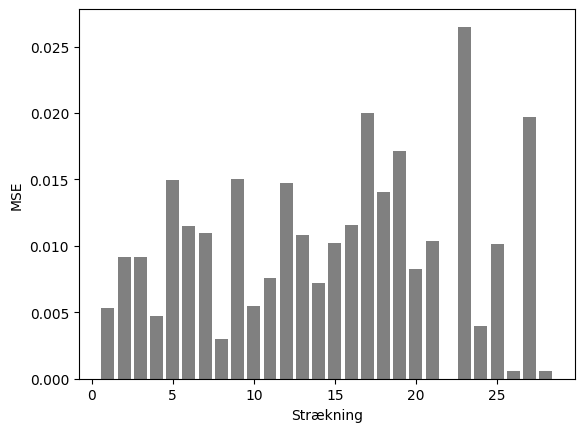

In [72]:
for i, results in data_each_strækning.items():
    strækning, _, _, _, _, mse, smapes = results
    plt.bar(strækning, mse, color = 'gray')
    plt.xlabel('Strækning')
    plt.ylabel('MSE')

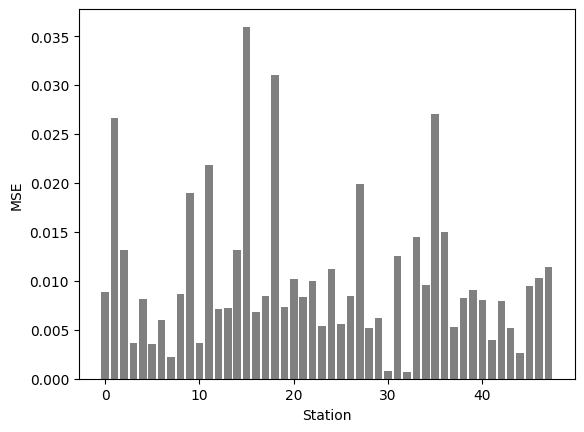

In [73]:
for i, results in data_each_station.items():
    station, _, _, _, _, mse, smapes = results
    plt.bar(station, mse, color = 'gray')
    plt.xlabel('Station')
    plt.ylabel('MSE')